<img src="https://www.gstatic.com/images/branding/googlelogo/1x/googlelogo_color_300x104dp.png" width="25%" alt="Google Cloud"/>

# **Face Blur with Google Cloud Vision API**

In [ ]:
# install the vision library
! pip install google-cloud-vision

In [2]:
# imports
from google.oauth2 import service_account
from google.cloud import vision
from typing import Sequence
from PIL import Image
from PIL import ImageFilter

In [ ]:
#@title **Enter your Project ID**

! gcloud auth login

# set project
PROJECT_ID = "ap-alto-ml-1000" #@param {type:"string"}
!gcloud config set project {PROJECT_ID}

YOUR_BUCKET = "gs://bkt-us-central1-data" #@param {type:"string"}

def getproject():
  p = !gcloud config get-value project
  print("Project: {}".format(p))
getproject()

def getuser():
  p = !gcloud config get-value account
  print("Logged in as user: {}".format(p))
getuser()

In [3]:
# enable the Cloud Vision API
! gcloud services enable vision.googleapis.com

In [4]:
# create a service account key file and upload
# how to -> https://cloud.google.com/iam/docs/keys-create-delete#creating
credentials = service_account.Credentials.from_service_account_file('/content/ap-alto-ml-1000-38a3a30ee47e.json')

In [5]:
# download the image
image_gcs_uri = f"{YOUR_BUCKET}/faces.jpg"
! gsutil cp {image_gcs_uri} .

Copying gs://bkt-us-central1-data/faces.jpg...
/ [1 files][ 74.6 KiB/ 74.6 KiB]                                                
Operation completed over 1 objects/74.6 KiB.                                     


In [17]:
# Cloud Vision API
def analyze_image_from_uri(image_uri: str, feature_types: Sequence, credentials) -> vision.AnnotateImageResponse:
    client = vision.ImageAnnotatorClient(credentials=credentials)
    image = vision.Image()
    image.source.image_uri = image_uri
    features = [vision.Feature(type_=feature_type) for feature_type in feature_types]
    request = vision.AnnotateImageRequest(image=image, features=features)
    response = client.annotate_image(request=request)
    return response

# retrieve the bounding box of a face
def get_face_box(response, face_img_index_to_blur):
  vertices = list(response.face_annotations[face_img_index_to_blur].bounding_poly.vertices)
  x, y = list(), list()
  for v in vertices:
    x.append(v.x)
    y.append(v.y)
  x0, x1 = min(x), max(x)
  y0, y1 = min(y), max(y)
  return x0, y0, x1, y1

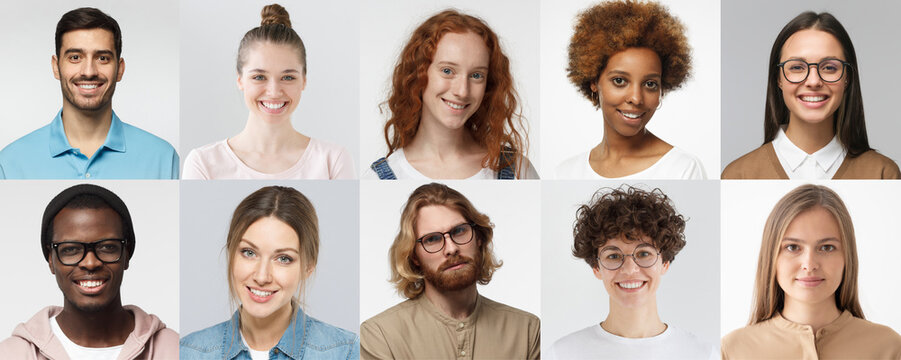

In [7]:
# view the original image
im = Image.open("/content/faces.jpg")
display(im)

In [8]:
# type of detection to perform
features = [vision.Feature.Type.FACE_DETECTION]

# make request to the vision api
response = analyze_image_from_uri(image_gcs_uri, features, credentials)

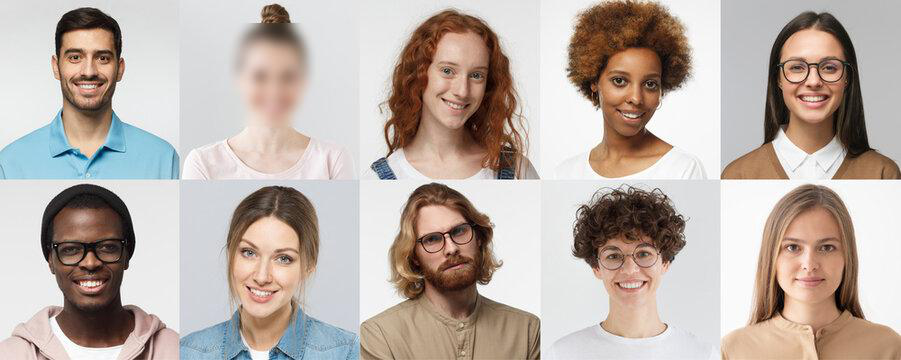

In [32]:
# SELECT A FACE INDEX TO BLUR
face_img_index_to_blur = 4

# Load the original image
original_image = Image.open("/content/faces.jpg")

# Get the dimensions of the original image
width, height = original_image.size

# Select the portion of the image you want to blur
x1, y1, x2, y2 = get_face_box(response, face_img_index_to_blur)

# Create a new image to store the blurred portion
blur_image = original_image.crop((x1, y1, x2, y2))

# Blur the image
blur_image = blur_image.filter(ImageFilter.GaussianBlur(radius=5))

# Overlay the blurred image on the original image
original_image.paste(blur_image, (x1, y1))

# Save the blurred image
original_image.save("blurred_image.jpg")

# view the blurred image
im = Image.open("blurred_image.jpg")
display(im)